# Initialization

This notebook shows how to design the scattering network for a given purpose. It initializes the network and the output path and stores the scattering network that will be used in parallel afterward.

In [1]:
%matplotlib inline

import pickle

from matplotlib import pyplot as plt
import numpy as np
import obspy

from scatseisnet import ScatteringNetwork
%config InlineBackend.figure_format = "svg"

## Parameters

We here load the database on which we will train the network on. The database object contains all the information about the data, such as the number of stations, the number of events, the number of channels, etc. Note that the directories are symbolic links to the actual data in order to avoid loading the data into the repository. 

## Scattering network

- `SEGMENT_DURATION_SEC` represents the window size used to chunk the data into pieces before passing it to the scattering network. We define it here in seconds since we know the data sampling rate.
- `STEP_DURATION_SEC` defines the sliding duration between two consecutive windows.
- `OCTAVES` indicates the number of octaves per layer. This value can be a tuple where the number of elements defines the number of layers. 
- `RESOLUTION` represents the number of wavelets per octave (must be of the size of `OCTAVES`)
- `QUALITY` represents the quality factor of the mother wavelet (must be of the size of `OCTAVES`)
- `SAMPLING_RATE` and other values allow turning the window and stepping durations into samples. If the sampling rate is unknown, it can be turned to a reduced frequency (1) or angular frequency ($2 \pi$).

Note that the type of pooling operation will be set later and not in this cell. It is not part of the network initiation. We instantiate the network from the meta parameters defined in the previous cell. The following cell allows defining the scattering network graph but does not compile it. The compilation stage occurs at the first use of the network.

In [58]:
# Parameters
window_duration = 0.015
sampling_rate = 2.5*1e6
window_bins = int(window_duration * sampling_rate)
print(f"Data points in each window:",window_bins)

bank_keyword_arguments = (
    {"octaves": 6, "resolution": 7, "quality": 1},
    {"octaves": 13, "resolution": 3, "quality": 1},
)

# Build model naming
model_name_1o = "_1o_"
for v in bank_keyword_arguments[0].values():
    model_name_1o = model_name_1o+str(v)
model_name_2o = "_2o_"
for v in bank_keyword_arguments[1].values():
    model_name_2o = model_name_2o+str(v)

# Network instance
model = ScatteringNetwork(
    bank_keyword_arguments,
    bins=window_bins,
    sampling_rate=sampling_rate,
)

Data points in each window: 37500


### Show filterbanks

We can easily access the different properties of the network and visualize the filter banks, for instance. Note that if the notebook implements the CPU version, there is no need to transfer the data to the CPU device with the `get` method.

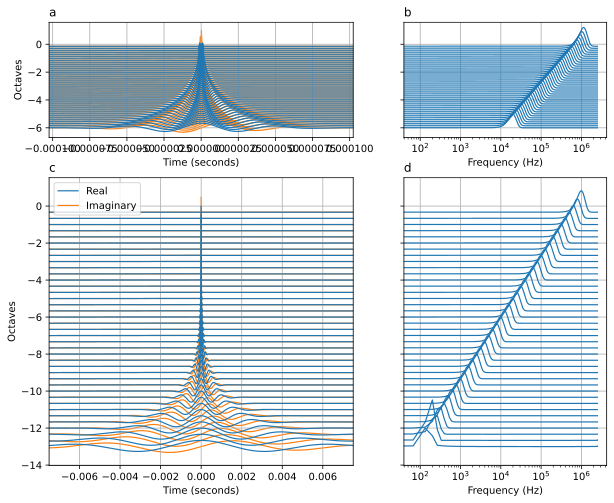

In [59]:
# model = pickle.load(open(filepath, "rb"))

# Show filter bank
gs = dict(height_ratios=(1, 2.5), width_ratios=(1.5, 1))
fig, axes = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw=gs, sharey="row")
for ax, bank in zip(axes, model.banks):

    # Temporal
    wavelets = bank.wavelets
    
    ratios = bank.ratios
    for wavelet, octave in zip(wavelets, ratios):
        y = wavelet
        y /= np.abs(y.max()) * 3
        ax[0].plot(bank.times, y.real + octave, color="C0", lw=1.2)
        ax[0].plot(bank.times, y.imag + octave, color="C1", zorder=1, lw=1.2)
    
    # Spectral
    sepctra = bank.spectra
    frequencies = bank.frequencies
    for spectrum, octave in zip(sepctra, ratios):
        y = spectrum
        y /= np.abs(y.max())
        ax[1].plot(frequencies, np.abs(y) + octave, color="C0", lw=1.2)
    
    # Labels
    width_max = min(2 * bank.widths.max(), bank.times.max())
    ax[0].set_xlim(-width_max, width_max)
    ax[0].set_xlabel("Time (seconds)")
    ax[0].set_ylabel("Octaves")
    ax[0].grid()
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].set_xscale("log")
    ax[1].grid()

axes[0, 0].set_title("a", loc="left")
axes[1, 0].legend(["Real", "Imaginary"], loc="upper left")
axes[1, 0].set_title("c", loc="left")
axes[0, 1].set_title("b", loc="left")
axes[1, 1].set_title("d", loc="left")

# Save
plt.show()

In [60]:
# Save network instance
filepath = "model/network_win_"+str(window_duration)+"_samp_"+str(sampling_rate*1e-6)+model_name_1o+model_name_2o+".pkl"
with open(filepath, "wb") as file:
    pickle.dump(model, file, protocol=pickle.HIGHEST_PROTOCOL)
print(filepath)

model/network_win_0.015_samp_2.5_1o_671_2o_1331.pkl


In [5]:
# bank.centers[0] * 2

## Notes L. Seydoux sur les choix d'octaves : 


    ° contrairement à l'intuition, prendre une fenêtre assez grande de données par rapport à la durée caractéristique des signaux est une bonne chose. Par exemple, pour des séismes d'une dizaine de secondes, on a eu des bonnes détection de très faire rapport signal-à-bruit sur des fenêtres de 60 secondes. Si tes signaux "grands" durent en moyenne 0.6 ms (comme je le lis sur ton schémas), je pense que tu feras de meilleures détections avec une fenêtre de 2 voire 3 ms par exemple.
    
    ° le spectre des signaux que tu cherches à détecter joue un rôle primordial dans le nombre d'octaves de la première couche. Ce nombre d'octave indique la couverture fréquentielle de la fréquence de Nyquist (donc fréquence d'échantillonnage / 2) à Nyquist / 2 ** n_octaves. Disons que si tes signaux ont de l'énergie de 0.1 à 1 MHz, alors tu devrais au moins choisir n_octaves = 5 pour bien les couvrir en fréquence. 
    
    ° Pour la seconde couche, c'est plutôt l'étendue temporelle des signaux qui est importante. Si tes signaux les plus énergétiques sont aussi les plus longs, alors tu devrais aller jusqu'à des fréquences de l'ordre de l'inverse de cette durée. En se basant sur les signaux que tu as montré, je pense que 1.6 kHz est une bonne fréquence minimale, donc il faudrait sans doute considérer de prendre 12 octaves pour la seconde couche (ce qui t'amènerais à prendre en compte des fréquences jusqu'à 1.2 kHz si mes calculs rapides sont bons).
    
    ° Enfin, le paramètre du nombre d'ondelettes par octaves dépend de si tu veux une représentation "dense" ou "parcimonieuse". Les papiers dédiés aux scattering nets proposent de faire une transformée dense à la première couche, puis parcimonieuse à la seconde. Par exemple, 8 ondelettes par octaves, puis 1 ondelette par octave. Ça peut aussi être un peu manipulé. 

In [37]:
octaves_1 = 5

In [38]:
freq_max_first = sampling_rate/2
print(f"Fréquence maximale (MHz) :",freq_max_first*1e-6) # MHz
freq_min_first = freq_max_first/(2**octaves_1)
print(f"Fréquence minimale (MHz) :",freq_min_first*1e-6) # MHz

Fréquence maximale (MHz) : 1.25
Fréquence minimale (MHz) : 0.0390625


In [40]:
octaves_2 = 11
freq_max_second = sampling_rate/2
freq_min_second = freq_max_second/(2**octaves_2)
print(f"Etendue temporelle maximales des signaux (s) :",1/freq_min_second) # MHz

Etendue temporelle maximales des signaux (s) : 0.0016384
